In [2]:
# Import
import os
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('/home/user/workdir/main/src/'))))

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-02-05 09:34:35.221775: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-05 09:34:35.251584: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 09:34:35.251614: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 09:34:35.251629: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-05 09:34:35.257336: I tensorflow/core/platform/cpu_feature_g

# Training (Nitrate)

In [2]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model'  # 모델 저장 경로

epochs = 1000  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch <= 1000: return 1e-3
    else: return 5e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-31 14:38:20.999850: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22341 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-31 14:38:21.001419: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22341 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-31 14:38:21.002979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22341 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-31 14:38:21.004378: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22217 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-31 14:38:47.441366: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:38:47.485714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:38:47.500725: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:38:47.624771: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-31 14:38:50.053464: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd45088e760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-31 14:38:50.053495: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-31 14:38:50.053499: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-31 14:38:50.05350

3/3 [==============================] - ETA: 0s - loss: 22.5838  INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-01-29.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-01-29.63/assets


3/3 [==============================] - 46s 7s/step - loss: 22.5838 - val_loss: 29.6342 - lr: 0.0010
Epoch 2/1000
2/3 [===================>..........] - ETA: 0s - loss: 17.7337INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-02-29.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-02-29.23/assets


3/3 [==============================] - 9s 5s/step - loss: 17.4800 - val_loss: 29.2317 - lr: 0.0010
Epoch 3/1000
3/3 [==============================] - ETA: 0s - loss: 13.8019INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-03-28.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-03-28.53/assets


3/3 [==============================] - 10s 5s/step - loss: 13.8019 - val_loss: 28.5344 - lr: 0.0010
Epoch 4/1000
3/3 [==============================] - ETA: 0s - loss: 11.7623INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-04-27.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-04-27.49/assets


3/3 [==============================] - 10s 5s/step - loss: 11.7623 - val_loss: 27.4855 - lr: 0.0010
Epoch 5/1000
3/3 [==============================] - ETA: 0s - loss: 10.7317INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-05-26.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-05-26.13/assets


3/3 [==============================] - 10s 5s/step - loss: 10.7317 - val_loss: 26.1272 - lr: 0.0010
Epoch 6/1000
3/3 [==============================] - ETA: 0s - loss: 10.1590INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-06-24.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-06-24.62/assets


3/3 [==============================] - 11s 5s/step - loss: 10.1590 - val_loss: 24.6246 - lr: 0.0010
Epoch 7/1000
3/3 [==============================] - ETA: 0s - loss: 9.7329INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-07-23.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-07-23.16/assets


3/3 [==============================] - 10s 5s/step - loss: 9.7329 - val_loss: 23.1596 - lr: 0.0010
Epoch 8/1000
3/3 [==============================] - ETA: 0s - loss: 9.3866INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-08-21.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-08-21.87/assets


3/3 [==============================] - 10s 5s/step - loss: 9.3866 - val_loss: 21.8661 - lr: 0.0010
Epoch 9/1000
3/3 [==============================] - ETA: 0s - loss: 9.0612INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-09-20.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-09-20.82/assets


3/3 [==============================] - 10s 5s/step - loss: 9.0612 - val_loss: 20.8165 - lr: 0.0010
Epoch 10/1000
3/3 [==============================] - ETA: 0s - loss: 8.7322INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-10-19.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-10-19.99/assets


3/3 [==============================] - 10s 5s/step - loss: 8.7322 - val_loss: 19.9875 - lr: 0.0010
Epoch 11/1000
3/3 [==============================] - ETA: 0s - loss: 8.4113INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-11-19.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-11-19.31/assets


3/3 [==============================] - 10s 5s/step - loss: 8.4113 - val_loss: 19.3094 - lr: 0.0010
Epoch 12/1000
3/3 [==============================] - ETA: 0s - loss: 8.1223INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-12-18.68/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-12-18.68/assets


3/3 [==============================] - 10s 5s/step - loss: 8.1223 - val_loss: 18.6816 - lr: 0.0010
Epoch 13/1000
2/3 [===================>..........] - ETA: 0s - loss: 7.8534INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-13-18.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-13-18.18/assets


3/3 [==============================] - 10s 5s/step - loss: 7.8362 - val_loss: 18.1835 - lr: 0.0010
Epoch 14/1000
3/3 [==============================] - ETA: 0s - loss: 7.5607INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-14-17.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-14-17.80/assets


3/3 [==============================] - 10s 5s/step - loss: 7.5607 - val_loss: 17.8012 - lr: 0.0010
Epoch 15/1000
3/3 [==============================] - ETA: 0s - loss: 7.2917INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-15-17.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-15-17.45/assets


3/3 [==============================] - 10s 5s/step - loss: 7.2917 - val_loss: 17.4461 - lr: 0.0010
Epoch 16/1000
3/3 [==============================] - ETA: 0s - loss: 7.0346INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-16-17.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-16-17.14/assets


3/3 [==============================] - 10s 5s/step - loss: 7.0346 - val_loss: 17.1359 - lr: 0.0010
Epoch 17/1000
3/3 [==============================] - ETA: 0s - loss: 6.7869INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-17-16.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-17-16.80/assets


3/3 [==============================] - 10s 5s/step - loss: 6.7869 - val_loss: 16.8030 - lr: 0.0010
Epoch 18/1000
3/3 [==============================] - ETA: 0s - loss: 6.5470INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-18-16.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-18-16.52/assets


3/3 [==============================] - 10s 5s/step - loss: 6.5470 - val_loss: 16.5187 - lr: 0.0010
Epoch 19/1000
3/3 [==============================] - ETA: 0s - loss: 6.3184INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-19-16.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-19-16.29/assets


3/3 [==============================] - 10s 5s/step - loss: 6.3184 - val_loss: 16.2925 - lr: 0.0010
Epoch 20/1000
3/3 [==============================] - ETA: 0s - loss: 6.0985INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-20-16.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-20-16.04/assets


3/3 [==============================] - 9s 4s/step - loss: 6.0985 - val_loss: 16.0412 - lr: 0.0010
Epoch 21/1000
3/3 [==============================] - ETA: 0s - loss: 5.8850INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-21-15.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-21-15.82/assets


3/3 [==============================] - 10s 5s/step - loss: 5.8850 - val_loss: 15.8227 - lr: 0.0010
Epoch 22/1000
3/3 [==============================] - ETA: 0s - loss: 5.6733INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-22-15.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-22-15.60/assets


3/3 [==============================] - 11s 5s/step - loss: 5.6733 - val_loss: 15.6037 - lr: 0.0010
Epoch 23/1000
3/3 [==============================] - ETA: 0s - loss: 5.4713INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-23-15.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-23-15.33/assets


3/3 [==============================] - 9s 4s/step - loss: 5.4713 - val_loss: 15.3335 - lr: 0.0010
Epoch 24/1000
2/3 [===================>..........] - ETA: 0s - loss: 5.2877INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-24-15.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-24-15.10/assets


3/3 [==============================] - 10s 5s/step - loss: 5.2772 - val_loss: 15.0994 - lr: 0.0010
Epoch 25/1000
3/3 [==============================] - ETA: 0s - loss: 5.0919INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-25-14.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-25-14.84/assets


3/3 [==============================] - 10s 5s/step - loss: 5.0919 - val_loss: 14.8397 - lr: 0.0010
Epoch 26/1000
3/3 [==============================] - ETA: 0s - loss: 4.9145INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-26-14.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-26-14.60/assets


3/3 [==============================] - 10s 5s/step - loss: 4.9145 - val_loss: 14.6030 - lr: 0.0010
Epoch 27/1000
3/3 [==============================] - ETA: 0s - loss: 4.7424INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-27-14.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-27-14.31/assets


3/3 [==============================] - 10s 5s/step - loss: 4.7424 - val_loss: 14.3057 - lr: 0.0010
Epoch 28/1000
3/3 [==============================] - ETA: 0s - loss: 4.5773INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-28-14.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-28-14.05/assets


3/3 [==============================] - 10s 5s/step - loss: 4.5773 - val_loss: 14.0507 - lr: 0.0010
Epoch 29/1000
3/3 [==============================] - ETA: 0s - loss: 4.4181INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-29-13.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-29-13.83/assets


3/3 [==============================] - 10s 5s/step - loss: 4.4181 - val_loss: 13.8349 - lr: 0.0010
Epoch 30/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.2858INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-30-13.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-30-13.57/assets


3/3 [==============================] - 10s 5s/step - loss: 4.2652 - val_loss: 13.5688 - lr: 0.0010
Epoch 31/1000
2/3 [===================>..........] - ETA: 0s - loss: 4.1289INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-31-13.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-31-13.33/assets


3/3 [==============================] - 10s 5s/step - loss: 4.1179 - val_loss: 13.3310 - lr: 0.0010
Epoch 32/1000
3/3 [==============================] - ETA: 0s - loss: 3.9741INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-32-13.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-32-13.02/assets


3/3 [==============================] - 10s 5s/step - loss: 3.9741 - val_loss: 13.0235 - lr: 0.0010
Epoch 33/1000
3/3 [==============================] - ETA: 0s - loss: 3.8409INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-33-12.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-33-12.82/assets


3/3 [==============================] - 10s 5s/step - loss: 3.8409 - val_loss: 12.8247 - lr: 0.0010
Epoch 34/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.7037INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-34-12.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-34-12.52/assets


3/3 [==============================] - 10s 5s/step - loss: 3.7031 - val_loss: 12.5167 - lr: 0.0010
Epoch 35/1000
3/3 [==============================] - ETA: 0s - loss: 3.5735INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-35-12.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-35-12.23/assets


3/3 [==============================] - 9s 4s/step - loss: 3.5735 - val_loss: 12.2250 - lr: 0.0010
Epoch 36/1000
3/3 [==============================] - ETA: 0s - loss: 3.4417INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-36-12.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-36-12.09/assets


3/3 [==============================] - 11s 5s/step - loss: 3.4417 - val_loss: 12.0899 - lr: 0.0010
Epoch 37/1000
3/3 [==============================] - ETA: 0s - loss: 3.3165INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-37-11.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-37-11.88/assets


3/3 [==============================] - 10s 5s/step - loss: 3.3165 - val_loss: 11.8835 - lr: 0.0010
Epoch 38/1000
3/3 [==============================] - ETA: 0s - loss: 3.1957INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-38-11.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-38-11.60/assets


3/3 [==============================] - 10s 5s/step - loss: 3.1957 - val_loss: 11.5994 - lr: 0.0010
Epoch 39/1000
2/3 [===================>..........] - ETA: 0s - loss: 3.0680INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-39-11.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-39-11.37/assets


3/3 [==============================] - 10s 5s/step - loss: 3.0764 - val_loss: 11.3747 - lr: 0.0010
Epoch 40/1000
3/3 [==============================] - ETA: 0s - loss: 2.9624INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-40-11.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-40-11.12/assets


3/3 [==============================] - 10s 5s/step - loss: 2.9624 - val_loss: 11.1219 - lr: 0.0010
Epoch 41/1000
3/3 [==============================] - ETA: 0s - loss: 2.8509INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-41-10.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-41-10.88/assets


3/3 [==============================] - 9s 4s/step - loss: 2.8509 - val_loss: 10.8840 - lr: 0.0010
Epoch 42/1000
3/3 [==============================] - ETA: 0s - loss: 2.7460INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-42-10.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-42-10.69/assets


3/3 [==============================] - 11s 5s/step - loss: 2.7460 - val_loss: 10.6864 - lr: 0.0010
Epoch 43/1000
3/3 [==============================] - ETA: 0s - loss: 2.6407INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-43-10.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-43-10.41/assets


3/3 [==============================] - 10s 5s/step - loss: 2.6407 - val_loss: 10.4123 - lr: 0.0010
Epoch 44/1000
3/3 [==============================] - ETA: 0s - loss: 2.5401INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-44-10.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-44-10.25/assets


3/3 [==============================] - 10s 5s/step - loss: 2.5401 - val_loss: 10.2536 - lr: 0.0010
Epoch 45/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.4477INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-45-10.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-45-10.07/assets


3/3 [==============================] - 9s 4s/step - loss: 2.4403 - val_loss: 10.0706 - lr: 0.0010
Epoch 46/1000
3/3 [==============================] - ETA: 0s - loss: 2.3476INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-46-9.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-46-9.82/assets


3/3 [==============================] - 11s 5s/step - loss: 2.3476 - val_loss: 9.8215 - lr: 0.0010
Epoch 47/1000
3/3 [==============================] - ETA: 0s - loss: 2.2555INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-47-9.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-47-9.51/assets


3/3 [==============================] - 10s 5s/step - loss: 2.2555 - val_loss: 9.5134 - lr: 0.0010
Epoch 48/1000
3/3 [==============================] - ETA: 0s - loss: 2.1682INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-48-9.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-48-9.24/assets


3/3 [==============================] - 9s 4s/step - loss: 2.1682 - val_loss: 9.2377 - lr: 0.0010
Epoch 49/1000
3/3 [==============================] - ETA: 0s - loss: 2.0817INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-49-8.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-49-8.98/assets


3/3 [==============================] - 11s 5s/step - loss: 2.0817 - val_loss: 8.9844 - lr: 0.0010
Epoch 50/1000
2/3 [===================>..........] - ETA: 0s - loss: 2.0058INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-50-8.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-50-8.62/assets


3/3 [==============================] - 11s 5s/step - loss: 2.0007 - val_loss: 8.6152 - lr: 0.0010
Epoch 51/1000
3/3 [==============================] - ETA: 0s - loss: 1.9177INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-51-8.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-51-8.39/assets


3/3 [==============================] - 11s 5s/step - loss: 1.9177 - val_loss: 8.3922 - lr: 0.0010
Epoch 52/1000
3/3 [==============================] - ETA: 0s - loss: 1.8408INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-52-8.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-52-8.23/assets


3/3 [==============================] - 9s 4s/step - loss: 1.8408 - val_loss: 8.2266 - lr: 0.0010
Epoch 53/1000
3/3 [==============================] - ETA: 0s - loss: 1.7705INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-53-8.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-53-8.00/assets


3/3 [==============================] - 11s 5s/step - loss: 1.7705 - val_loss: 8.0029 - lr: 0.0010
Epoch 54/1000
3/3 [==============================] - ETA: 0s - loss: 1.6969INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-54-7.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-54-7.70/assets


3/3 [==============================] - 11s 5s/step - loss: 1.6969 - val_loss: 7.7028 - lr: 0.0010
Epoch 55/1000
3/3 [==============================] - ETA: 0s - loss: 1.6262INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-55-7.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-55-7.58/assets


3/3 [==============================] - 9s 4s/step - loss: 1.6262 - val_loss: 7.5837 - lr: 0.0010
Epoch 56/1000
3/3 [==============================] - ETA: 0s - loss: 1.5610INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-56-7.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-56-7.32/assets


3/3 [==============================] - 11s 5s/step - loss: 1.5610 - val_loss: 7.3216 - lr: 0.0010
Epoch 57/1000
3/3 [==============================] - ETA: 0s - loss: 1.4939INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-57-7.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-57-7.06/assets


3/3 [==============================] - 11s 5s/step - loss: 1.4939 - val_loss: 7.0561 - lr: 0.0010
Epoch 58/1000
3/3 [==============================] - ETA: 0s - loss: 1.4282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-58-6.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-58-6.99/assets


3/3 [==============================] - 9s 4s/step - loss: 1.4282 - val_loss: 6.9896 - lr: 0.0010
Epoch 59/1000
3/3 [==============================] - ETA: 0s - loss: 1.3662INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-59-6.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-59-6.87/assets


3/3 [==============================] - 11s 5s/step - loss: 1.3662 - val_loss: 6.8745 - lr: 0.0010
Epoch 60/1000
3/3 [==============================] - ETA: 0s - loss: 1.3075INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-60-6.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-60-6.55/assets


3/3 [==============================] - 11s 5s/step - loss: 1.3075 - val_loss: 6.5502 - lr: 0.0010
Epoch 61/1000
3/3 [==============================] - ETA: 0s - loss: 1.2500INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-61-6.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-61-6.46/assets


3/3 [==============================] - 9s 4s/step - loss: 1.2500 - val_loss: 6.4643 - lr: 0.0010
Epoch 62/1000
3/3 [==============================] - ETA: 0s - loss: 1.1950INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-62-6.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-62-6.30/assets


3/3 [==============================] - 11s 5s/step - loss: 1.1950 - val_loss: 6.3036 - lr: 0.0010
Epoch 63/1000
3/3 [==============================] - ETA: 0s - loss: 1.1424INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-63-6.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-63-6.12/assets


3/3 [==============================] - 11s 5s/step - loss: 1.1424 - val_loss: 6.1203 - lr: 0.0010
Epoch 64/1000
3/3 [==============================] - ETA: 0s - loss: 1.0918INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-64-6.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-64-6.07/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0918 - val_loss: 6.0721 - lr: 0.0010
Epoch 65/1000
3/3 [==============================] - ETA: 0s - loss: 1.0460INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-65-5.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-65-5.82/assets


3/3 [==============================] - 11s 5s/step - loss: 1.0460 - val_loss: 5.8191 - lr: 0.0010
Epoch 66/1000
2/3 [===================>..........] - ETA: 0s - loss: 1.0081INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-66-5.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-66-5.63/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0001 - val_loss: 5.6314 - lr: 0.0010
Epoch 67/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.9528INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-67-5.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-67-5.42/assets


3/3 [==============================] - 11s 6s/step - loss: 0.9547 - val_loss: 5.4202 - lr: 0.0010
Epoch 68/1000
3/3 [==============================] - ETA: 0s - loss: 0.9147INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-68-5.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-68-5.20/assets


3/3 [==============================] - 11s 5s/step - loss: 0.9147 - val_loss: 5.1971 - lr: 0.0010
Epoch 69/1000
3/3 [==============================] - ETA: 0s - loss: 0.8754INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-69-5.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-69-5.06/assets


3/3 [==============================] - 9s 4s/step - loss: 0.8754 - val_loss: 5.0616 - lr: 0.0010
Epoch 70/1000
3/3 [==============================] - ETA: 0s - loss: 0.8354INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-70-5.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-70-5.00/assets


3/3 [==============================] - 11s 6s/step - loss: 0.8354 - val_loss: 5.0031 - lr: 0.0010
Epoch 71/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.8069INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-71-4.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-71-4.88/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7963 - val_loss: 4.8829 - lr: 0.0010
Epoch 72/1000
3/3 [==============================] - ETA: 0s - loss: 0.7615INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-72-4.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-72-4.61/assets


3/3 [==============================] - 11s 6s/step - loss: 0.7615 - val_loss: 4.6087 - lr: 0.0010
Epoch 73/1000
3/3 [==============================] - ETA: 0s - loss: 0.7242INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-73-4.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-73-4.42/assets


3/3 [==============================] - 11s 5s/step - loss: 0.7242 - val_loss: 4.4216 - lr: 0.0010
Epoch 74/1000
3/3 [==============================] - ETA: 0s - loss: 0.6946INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-74-4.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-74-4.34/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6946 - val_loss: 4.3433 - lr: 0.0010
Epoch 75/1000
3/3 [==============================] - ETA: 0s - loss: 0.6602INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-75-4.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-75-4.32/assets


3/3 [==============================] - 11s 6s/step - loss: 0.6602 - val_loss: 4.3182 - lr: 0.0010
Epoch 76/1000
3/3 [==============================] - ETA: 0s - loss: 0.6327INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-76-4.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-76-4.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6327 - val_loss: 4.1421 - lr: 0.0010
Epoch 77/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.6139INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-77-4.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-77-4.07/assets


3/3 [==============================] - 11s 6s/step - loss: 0.6009 - val_loss: 4.0658 - lr: 0.0010
Epoch 78/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.5743 - val_loss: 4.0817 - lr: 0.0010
Epoch 79/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.5518INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-79-3.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-79-3.97/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5506 - val_loss: 3.9660 - lr: 0.0010
Epoch 80/1000
3/3 [==============================] - ETA: 0s - loss: 0.5256INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-80-3.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-80-3.88/assets


3/3 [==============================] - 11s 6s/step - loss: 0.5256 - val_loss: 3.8780 - lr: 0.0010
Epoch 81/1000
3/3 [==============================] - ETA: 0s - loss: 0.5016INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-81-3.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-81-3.74/assets


3/3 [==============================] - 11s 5s/step - loss: 0.5016 - val_loss: 3.7353 - lr: 0.0010
Epoch 82/1000
3/3 [==============================] - ETA: 0s - loss: 0.4779INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-82-3.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-82-3.69/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4779 - val_loss: 3.6852 - lr: 0.0010
Epoch 83/1000
3/3 [==============================] - ETA: 0s - loss: 0.4564INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-83-3.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-83-3.60/assets


3/3 [==============================] - 11s 6s/step - loss: 0.4564 - val_loss: 3.6049 - lr: 0.0010
Epoch 84/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.4365INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-84-3.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-84-3.48/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4357 - val_loss: 3.4803 - lr: 0.0010
Epoch 85/1000
3/3 [==============================] - ETA: 0s - loss: 0.4151INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-85-3.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-85-3.39/assets


3/3 [==============================] - 11s 6s/step - loss: 0.4151 - val_loss: 3.3889 - lr: 0.0010
Epoch 86/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3956INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-86-3.26/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-86-3.26/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3969 - val_loss: 3.2620 - lr: 0.0010
Epoch 87/1000
3/3 [==============================] - ETA: 0s - loss: 0.3801INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-87-3.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-87-3.22/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3801 - val_loss: 3.2220 - lr: 0.0010
Epoch 88/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.3622INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-88-3.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-88-3.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3627 - val_loss: 3.1097 - lr: 0.0010
Epoch 89/1000
3/3 [==============================] - 0s 228ms/step - loss: 0.3469 - val_loss: 3.1803 - lr: 0.0010
Epoch 90/1000
3/3 [==============================] - ETA: 0s - loss: 0.3340INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-90-3.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-90-3.05/assets


3/3 [==============================] - 11s 6s/step - loss: 0.3340 - val_loss: 3.0484 - lr: 0.0010
Epoch 91/1000
3/3 [==============================] - ETA: 0s - loss: 0.3185INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-91-2.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-91-2.95/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3185 - val_loss: 2.9494 - lr: 0.0010
Epoch 92/1000
3/3 [==============================] - ETA: 0s - loss: 0.3057INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-92-2.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-92-2.91/assets


3/3 [==============================] - 11s 6s/step - loss: 0.3057 - val_loss: 2.9054 - lr: 0.0010
Epoch 93/1000
3/3 [==============================] - ETA: 0s - loss: 0.2941INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-93-2.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-93-2.77/assets


3/3 [==============================] - 11s 5s/step - loss: 0.2941 - val_loss: 2.7675 - lr: 0.0010
Epoch 94/1000
3/3 [==============================] - ETA: 0s - loss: 0.2808INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-94-2.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-94-2.66/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2808 - val_loss: 2.6580 - lr: 0.0010
Epoch 95/1000
3/3 [==============================] - ETA: 0s - loss: 0.2674INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-95-2.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-95-2.58/assets


3/3 [==============================] - 11s 6s/step - loss: 0.2674 - val_loss: 2.5774 - lr: 0.0010
Epoch 96/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.2588INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-96-2.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-96-2.57/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2579 - val_loss: 2.5663 - lr: 0.0010
Epoch 97/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.2446 - val_loss: 2.5832 - lr: 0.0010
Epoch 98/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.2366 - val_loss: 2.5766 - lr: 0.0010
Epoch 99/1000
3/3 [==============================] - ETA: 0s - loss: 0.2265INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-99-2.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-99-2.56/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2265 - val_loss: 2.5608 - lr: 0.0010
Epoch 100/1000
3/3 [==============================] - ETA: 0s - loss: 0.2179INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-100-2.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-100-2.47/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2179 - val_loss: 2.4701 - lr: 0.0010
Epoch 101/1000
3/3 [==============================] - ETA: 0s - loss: 0.2110INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-101-2.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-101-2.38/assets


3/3 [==============================] - 11s 6s/step - loss: 0.2110 - val_loss: 2.3814 - lr: 0.0010
Epoch 102/1000
3/3 [==============================] - ETA: 0s - loss: 0.2039INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-102-2.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-102-2.29/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2039 - val_loss: 2.2917 - lr: 0.0010
Epoch 103/1000
3/3 [==============================] - ETA: 0s - loss: 0.1954INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-103-2.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-103-2.27/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1954 - val_loss: 2.2718 - lr: 0.0010
Epoch 104/1000
3/3 [==============================] - ETA: 0s - loss: 0.1887INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-104-2.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-104-2.22/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1887 - val_loss: 2.2247 - lr: 0.0010
Epoch 105/1000
3/3 [==============================] - ETA: 0s - loss: 0.1835INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-105-2.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-105-2.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1835 - val_loss: 2.1045 - lr: 0.0010
Epoch 106/1000
3/3 [==============================] - ETA: 0s - loss: 0.1756INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-106-2.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-106-2.01/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1756 - val_loss: 2.0108 - lr: 0.0010
Epoch 107/1000
3/3 [==============================] - ETA: 0s - loss: 0.1725INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-107-1.88/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-107-1.88/assets


3/3 [==============================] - 11s 6s/step - loss: 0.1725 - val_loss: 1.8846 - lr: 0.0010
Epoch 108/1000
3/3 [==============================] - ETA: 0s - loss: 0.1655INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-108-1.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-108-1.86/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1655 - val_loss: 1.8631 - lr: 0.0010
Epoch 109/1000
3/3 [==============================] - ETA: 0s - loss: 0.1594INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-109-1.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-109-1.84/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1594 - val_loss: 1.8397 - lr: 0.0010
Epoch 110/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1549INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-110-1.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-110-1.76/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1543 - val_loss: 1.7642 - lr: 0.0010
Epoch 111/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.1501 - val_loss: 1.7784 - lr: 0.0010
Epoch 112/1000
3/3 [==============================] - ETA: 0s - loss: 0.1472INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-112-1.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-112-1.70/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1472 - val_loss: 1.7016 - lr: 0.0010
Epoch 113/1000
3/3 [==============================] - ETA: 0s - loss: 0.1423INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-113-1.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-113-1.62/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1423 - val_loss: 1.6161 - lr: 0.0010
Epoch 114/1000
3/3 [==============================] - ETA: 0s - loss: 0.1378INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-114-1.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-114-1.56/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1378 - val_loss: 1.5551 - lr: 0.0010
Epoch 115/1000
3/3 [==============================] - ETA: 0s - loss: 0.1388INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-115-1.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-115-1.46/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1388 - val_loss: 1.4641 - lr: 0.0010
Epoch 116/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1403INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-116-1.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-116-1.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1391 - val_loss: 1.3786 - lr: 0.0010
Epoch 117/1000
3/3 [==============================] - ETA: 0s - loss: 0.1317INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-117-1.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-117-1.31/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1317 - val_loss: 1.3051 - lr: 0.0010
Epoch 118/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-118-1.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-118-1.25/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1291 - val_loss: 1.2458 - lr: 0.0010
Epoch 119/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.1253 - val_loss: 1.2832 - lr: 0.0010
Epoch 120/1000
3/3 [==============================] - ETA: 0s - loss: 0.1222INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-120-1.24/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-120-1.24/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1222 - val_loss: 1.2383 - lr: 0.0010
Epoch 121/1000
3/3 [==============================] - ETA: 0s - loss: 0.1181INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-121-1.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-121-1.18/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1181 - val_loss: 1.1778 - lr: 0.0010
Epoch 122/1000
3/3 [==============================] - ETA: 0s - loss: 0.1166INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-122-1.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-122-1.05/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1166 - val_loss: 1.0450 - lr: 0.0010
Epoch 123/1000
3/3 [==============================] - ETA: 0s - loss: 0.1166INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-123-1.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-123-1.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1166 - val_loss: 1.0416 - lr: 0.0010
Epoch 124/1000
3/3 [==============================] - ETA: 0s - loss: 0.1135INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-124-1.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-124-1.01/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1135 - val_loss: 1.0073 - lr: 0.0010
Epoch 125/1000
3/3 [==============================] - ETA: 0s - loss: 0.1121INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-125-0.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-125-0.98/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1121 - val_loss: 0.9810 - lr: 0.0010
Epoch 126/1000
3/3 [==============================] - ETA: 0s - loss: 0.1100INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-126-0.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-126-0.94/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1100 - val_loss: 0.9390 - lr: 0.0010
Epoch 127/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.1073 - val_loss: 0.9525 - lr: 0.0010
Epoch 128/1000
3/3 [==============================] - ETA: 0s - loss: 0.1057INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-128-0.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-128-0.87/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1057 - val_loss: 0.8710 - lr: 0.0010
Epoch 129/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.1037INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-129-0.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-129-0.83/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1044 - val_loss: 0.8285 - lr: 0.0010
Epoch 130/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.1025 - val_loss: 0.8430 - lr: 0.0010
Epoch 131/1000
3/3 [==============================] - ETA: 0s - loss: 0.1006INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-131-0.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-131-0.77/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1006 - val_loss: 0.7715 - lr: 0.0010
Epoch 132/1000
3/3 [==============================] - ETA: 0s - loss: 0.0998INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-132-0.76/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-132-0.76/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0998 - val_loss: 0.7591 - lr: 0.0010
Epoch 133/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0980 - val_loss: 0.7876 - lr: 0.0010
Epoch 134/1000
3/3 [==============================] - ETA: 0s - loss: 0.0964INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-134-0.74/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-134-0.74/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0964 - val_loss: 0.7351 - lr: 0.0010
Epoch 135/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0946 - val_loss: 0.7851 - lr: 0.0010
Epoch 136/1000
3/3 [==============================] - ETA: 0s - loss: 0.0951INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-136-0.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-136-0.66/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0951 - val_loss: 0.6609 - lr: 0.0010
Epoch 137/1000
3/3 [==============================] - ETA: 0s - loss: 0.0964INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-137-0.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-137-0.63/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0964 - val_loss: 0.6314 - lr: 0.0010
Epoch 138/1000
3/3 [==============================] - ETA: 0s - loss: 0.0934INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-138-0.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-138-0.57/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0934 - val_loss: 0.5735 - lr: 0.0010
Epoch 139/1000
3/3 [==============================] - ETA: 0s - loss: 0.0931INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-139-0.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-139-0.52/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0931 - val_loss: 0.5156 - lr: 0.0010
Epoch 140/1000
3/3 [==============================] - ETA: 0s - loss: 0.0923INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-140-0.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-140-0.47/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0923 - val_loss: 0.4704 - lr: 0.0010
Epoch 141/1000
3/3 [==============================] - ETA: 0s - loss: 0.0921INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-141-0.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-141-0.45/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0921 - val_loss: 0.4513 - lr: 0.0010
Epoch 142/1000
3/3 [==============================] - ETA: 0s - loss: 0.0926INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-142-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-142-0.42/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0926 - val_loss: 0.4218 - lr: 0.0010
Epoch 143/1000
3/3 [==============================] - ETA: 0s - loss: 0.0912INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-143-0.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-143-0.41/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0912 - val_loss: 0.4099 - lr: 0.0010
Epoch 144/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0904 - val_loss: 0.4138 - lr: 0.0010
Epoch 145/1000
3/3 [==============================] - ETA: 0s - loss: 0.0875INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-145-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-145-0.38/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0875 - val_loss: 0.3843 - lr: 0.0010
Epoch 146/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0868 - val_loss: 0.3962 - lr: 0.0010
Epoch 147/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0879 - val_loss: 0.4020 - lr: 0.0010
Epoch 148/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0865 - val_loss: 0.4052 - lr: 0.0010
Epoch 149/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0849 - val_loss: 0.3995 - lr: 0.0010
Epoch 150/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0849 - val_loss: 0.3980 - lr: 0.0010
Epoch 151/1000
3/3 [==============================] - ETA: 0s - loss: 0.0856INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-151-0.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-151-0.37/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0856 - val_loss: 0.3741 - lr: 0.0010
Epoch 152/1000
3/3 [==============================] - ETA: 0s - loss: 0.0843INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-152-0.33/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-152-0.33/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0843 - val_loss: 0.3273 - lr: 0.0010
Epoch 153/1000
3/3 [==============================] - ETA: 0s - loss: 0.0849INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-153-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-153-0.30/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0849 - val_loss: 0.3038 - lr: 0.0010
Epoch 154/1000
3/3 [==============================] - ETA: 0s - loss: 0.0842INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-154-0.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-154-0.28/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0842 - val_loss: 0.2785 - lr: 0.0010
Epoch 155/1000
3/3 [==============================] - ETA: 0s - loss: 0.0828INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-155-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-155-0.25/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0828 - val_loss: 0.2546 - lr: 0.0010
Epoch 156/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0850 - val_loss: 0.2770 - lr: 0.0010
Epoch 157/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0847 - val_loss: 0.2934 - lr: 0.0010
Epoch 158/1000
3/3 [==============================] - ETA: 0s - loss: 0.0834INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-158-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-158-0.25/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0834 - val_loss: 0.2545 - lr: 0.0010
Epoch 159/1000
3/3 [==============================] - ETA: 0s - loss: 0.0827INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-159-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-159-0.23/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0827 - val_loss: 0.2253 - lr: 0.0010
Epoch 160/1000
3/3 [==============================] - ETA: 0s - loss: 0.0826INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-160-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-160-0.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0826 - val_loss: 0.2041 - lr: 0.0010
Epoch 161/1000
3/3 [==============================] - ETA: 0s - loss: 0.0837INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-161-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-161-0.20/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0837 - val_loss: 0.2035 - lr: 0.0010
Epoch 162/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0829 - val_loss: 0.2037 - lr: 0.0010
Epoch 163/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0834INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-163-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-163-0.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0839 - val_loss: 0.1966 - lr: 0.0010
Epoch 164/1000
3/3 [==============================] - ETA: 0s - loss: 0.0833INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-164-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-164-0.19/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0833 - val_loss: 0.1922 - lr: 0.0010
Epoch 165/1000
3/3 [==============================] - ETA: 0s - loss: 0.0807INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-165-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-165-0.19/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0807 - val_loss: 0.1867 - lr: 0.0010
Epoch 166/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0809 - val_loss: 0.1912 - lr: 0.0010
Epoch 167/1000
3/3 [==============================] - ETA: 0s - loss: 0.0824INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-167-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-167-0.16/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0824 - val_loss: 0.1588 - lr: 0.0010
Epoch 168/1000
3/3 [==============================] - ETA: 0s - loss: 0.0829INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-168-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-168-0.16/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0829 - val_loss: 0.1574 - lr: 0.0010
Epoch 169/1000
3/3 [==============================] - ETA: 0s - loss: 0.0807INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-169-0.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-169-0.15/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0807 - val_loss: 0.1485 - lr: 0.0010
Epoch 170/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0816 - val_loss: 0.1511 - lr: 0.0010
Epoch 171/1000
3/3 [==============================] - ETA: 0s - loss: 0.0816INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-171-0.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-171-0.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0816 - val_loss: 0.1403 - lr: 0.0010
Epoch 172/1000
3/3 [==============================] - ETA: 0s - loss: 0.0839INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-172-0.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-172-0.13/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0839 - val_loss: 0.1314 - lr: 0.0010
Epoch 173/1000
3/3 [==============================] - ETA: 0s - loss: 0.0836INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-173-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-173-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0836 - val_loss: 0.1233 - lr: 0.0010
Epoch 174/1000
3/3 [==============================] - ETA: 0s - loss: 0.0824INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-174-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-174-0.12/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0824 - val_loss: 0.1210 - lr: 0.0010
Epoch 175/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0811 - val_loss: 0.1289 - lr: 0.0010
Epoch 176/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0801 - val_loss: 0.1319 - lr: 0.0010
Epoch 177/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0807 - val_loss: 0.1347 - lr: 0.0010
Epoch 178/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0797 - val_loss: 0.1632 - lr: 0.0010
Epoch 179/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0801 - val_loss: 0.1383 - lr: 0.0010
Epoch 180/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0798INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-180-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-180-0.12/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0797 - val_loss: 0.1162 - lr: 0.0010
Epoch 181/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0811 - val_loss: 0.1166 - lr: 0.0010
Epoch 182/1000
3/3 [==============================] - ETA: 0s - loss: 0.0835INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-182-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-182-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0835 - val_loss: 0.1090 - lr: 0.0010
Epoch 183/1000
3/3 [==============================] - ETA: 0s - loss: 0.0837INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-183-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-183-0.10/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0837 - val_loss: 0.1032 - lr: 0.0010
Epoch 184/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0810 - val_loss: 0.1035 - lr: 0.0010
Epoch 185/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0798INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-185-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-185-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0797 - val_loss: 0.0979 - lr: 0.0010
Epoch 186/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0789 - val_loss: 0.1020 - lr: 0.0010
Epoch 187/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0784INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-187-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-187-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0784 - val_loss: 0.0973 - lr: 0.0010
Epoch 188/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0794 - val_loss: 0.0982 - lr: 0.0010
Epoch 189/1000
3/3 [==============================] - ETA: 0s - loss: 0.0788INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-189-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-189-0.10/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0788 - val_loss: 0.0967 - lr: 0.0010
Epoch 190/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0807 - val_loss: 0.0979 - lr: 0.0010
Epoch 191/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0774INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-191-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-191-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0776 - val_loss: 0.0967 - lr: 0.0010
Epoch 192/1000
3/3 [==============================] - ETA: 0s - loss: 0.0787INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-192-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-192-0.10/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0787 - val_loss: 0.0955 - lr: 0.0010
Epoch 193/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0779 - val_loss: 0.0960 - lr: 0.0010
Epoch 194/1000
3/3 [==============================] - ETA: 0s - loss: 0.0788INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-194-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-194-0.09/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0788 - val_loss: 0.0935 - lr: 0.0010
Epoch 195/1000
3/3 [==============================] - ETA: 0s - loss: 0.0782INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-195-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-195-0.09/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0782 - val_loss: 0.0928 - lr: 0.0010
Epoch 196/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0775INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-196-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-196-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0779 - val_loss: 0.0924 - lr: 0.0010
Epoch 197/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0790 - val_loss: 0.1032 - lr: 0.0010
Epoch 198/1000
3/3 [==============================] - ETA: 0s - loss: 0.0812INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-198-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-198-0.09/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0812 - val_loss: 0.0893 - lr: 0.0010
Epoch 199/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0783 - val_loss: 0.0913 - lr: 0.0010
Epoch 200/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0807 - val_loss: 0.0986 - lr: 0.0010
Epoch 201/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0784 - val_loss: 0.1042 - lr: 0.0010
Epoch 202/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0779 - val_loss: 0.0974 - lr: 0.0010
Epoch 203/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0782 - val_loss: 0.0977 - lr: 0.0010
Epoch 204/1000
3/3 [==============================] - ETA: 0s - loss: 0.0783INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-204-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-204-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0783 - val_loss: 0.0866 - lr: 0.0010
Epoch 205/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0787 - val_loss: 0.0886 - lr: 0.0010
Epoch 206/1000
3/3 [==============================] - ETA: 0s - loss: 0.0801INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-206-0.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-206-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0801 - val_loss: 0.0856 - lr: 0.0010
Epoch 207/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0783 - val_loss: 0.0886 - lr: 0.0010
Epoch 208/1000
3/3 [==============================] - ETA: 0s - loss: 0.0794INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-208-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-208-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0794 - val_loss: 0.0833 - lr: 0.0010
Epoch 209/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0792 - val_loss: 0.0873 - lr: 0.0010
Epoch 210/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0781 - val_loss: 0.0853 - lr: 0.0010
Epoch 211/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0778 - val_loss: 0.0906 - lr: 0.0010
Epoch 212/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0797 - val_loss: 0.0903 - lr: 0.0010
Epoch 213/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0788 - val_loss: 0.0865 - lr: 0.0010
Epoch 214/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0780 - val_loss: 0.0852 - lr: 0.0010
Epoch 215/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0779 - val_loss: 0.0845 - lr: 0.0010
Epoch 216/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0783 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-224-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0790 - val_loss: 0.0823 - lr: 0.0010
Epoch 225/1000
3/3 [==============================] - 0s 226ms/step - loss: 0.0782 - val_loss: 0.0907 - lr: 0.0010
Epoch 226/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0778 - val_loss: 0.0840 - lr: 0.0010
Epoch 227/1000
3/3 [==============================] - ETA: 0s - loss: 0.0789INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-227-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-227-0.08/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0789 - val_loss: 0.0818 - lr: 0.0010
Epoch 228/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0778 - val_loss: 0.0849 - lr: 0.0010
Epoch 229/1000
3/3 [==============================] - 1s 232ms/step - loss: 0.0783 - val_loss: 0.0855 - lr: 0.0010
Epoch 230/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0779 - val_loss: 0.0821 - lr: 0.0010
Epoch 231/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0783 - val_loss: 0.0827 - lr: 0.0010
Epoch 232/1000
3/3 [==============================] - ETA: 0s - loss: 0.0769INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-232-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-232-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0769 - val_loss: 0.0812 - lr: 0.0010
Epoch 233/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0764 - val_loss: 0.0835 - lr: 0.0010
Epoch 234/1000
3/3 [==============================] - 0s 185ms/step - loss: 0.0773 - val_loss: 0.0824 - lr: 0.0010
Epoch 235/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0760 - val_loss: 0.0812 - lr: 0.0010
Epoch 236/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0758 - val_loss: 0.0820 - lr: 0.0010
Epoch 237/1000
3/3 [==============================] - ETA: 0s - loss: 0.0764INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-237-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-237-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0764 - val_loss: 0.0796 - lr: 0.0010
Epoch 238/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0762 - val_loss: 0.0852 - lr: 0.0010
Epoch 239/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0757 - val_loss: 0.0866 - lr: 0.0010
Epoch 240/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0755 - val_loss: 0.0805 - lr: 0.0010
Epoch 241/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0762 - val_loss: 0.0823 - lr: 0.0010
Epoch 242/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0762 - val_loss: 0.0829 - lr: 0.0010
Epoch 243/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0756 - val_loss: 0.0839 - lr: 0.0010
Epoch 244/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0758 - val_loss: 0.0985 - lr: 0.0010
Epoch 245/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0770 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-275-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0757 - val_loss: 0.0796 - lr: 0.0010
Epoch 276/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0767 - val_loss: 0.0810 - lr: 0.0010
Epoch 277/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0763 - val_loss: 0.0829 - lr: 0.0010
Epoch 278/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0751 - val_loss: 0.0836 - lr: 0.0010
Epoch 279/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0758 - val_loss: 0.0813 - lr: 0.0010
Epoch 280/1000
3/3 [==============================] - ETA: 0s - loss: 0.0751INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-280-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-280-0.08/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0751 - val_loss: 0.0790 - lr: 0.0010
Epoch 281/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0744 - val_loss: 0.0862 - lr: 0.0010
Epoch 282/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0758 - val_loss: 0.0817 - lr: 0.0010
Epoch 283/1000
3/3 [==============================] - 1s 256ms/step - loss: 0.0746 - val_loss: 0.0856 - lr: 0.0010
Epoch 284/1000
3/3 [==============================] - 0s 183ms/step - loss: 0.0752 - val_loss: 0.0914 - lr: 0.0010
Epoch 285/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0746 - val_loss: 0.0806 - lr: 0.0010
Epoch 286/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0777 - val_loss: 0.0818 - lr: 0.0010
Epoch 287/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0750 - val_loss: 0.0813 - lr: 0.0010
Epoch 288/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0766 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-292-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0760 - val_loss: 0.0786 - lr: 0.0010
Epoch 293/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0740 - val_loss: 0.0848 - lr: 0.0010
Epoch 294/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0746 - val_loss: 0.0813 - lr: 0.0010
Epoch 295/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0748 - val_loss: 0.0853 - lr: 0.0010
Epoch 296/1000
3/3 [==============================] - 0s 198ms/step - loss: 0.0746 - val_loss: 0.0948 - lr: 0.0010
Epoch 297/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0745 - val_loss: 0.0921 - lr: 0.0010
Epoch 298/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0756 - val_loss: 0.0841 - lr: 0.0010
Epoch 299/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0749 - val_loss: 0.0887 - lr: 0.0010
Epoch 300/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0744 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-317-0.08/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0742 - val_loss: 0.0766 - lr: 0.0010
Epoch 318/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0739 - val_loss: 0.0777 - lr: 0.0010
Epoch 319/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0741 - val_loss: 0.0776 - lr: 0.0010
Epoch 320/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0742 - val_loss: 0.0854 - lr: 0.0010
Epoch 321/1000
3/3 [==============================] - 1s 243ms/step - loss: 0.0753 - val_loss: 0.0850 - lr: 0.0010
Epoch 322/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0760 - val_loss: 0.0794 - lr: 0.0010
Epoch 323/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0762 - val_loss: 0.0780 - lr: 0.0010
Epoch 324/1000
3/3 [==============================] - 0s 191ms/step - loss: 0.0749 - val_loss: 0.0772 - lr: 0.0010
Epoch 325/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0739 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-352-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0741 - val_loss: 0.0763 - lr: 0.0010
Epoch 353/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0741 - val_loss: 0.0776 - lr: 0.0010
Epoch 354/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0753 - val_loss: 0.0783 - lr: 0.0010
Epoch 355/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0745 - val_loss: 0.0788 - lr: 0.0010
Epoch 356/1000
3/3 [==============================] - 1s 234ms/step - loss: 0.0736 - val_loss: 0.0769 - lr: 0.0010
Epoch 357/1000
3/3 [==============================] - ETA: 0s - loss: 0.0743INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-357-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-357-0.08/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0743 - val_loss: 0.0752 - lr: 0.0010
Epoch 358/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0725 - val_loss: 0.0772 - lr: 0.0010
Epoch 359/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0728 - val_loss: 0.0754 - lr: 0.0010
Epoch 360/1000
3/3 [==============================] - 1s 228ms/step - loss: 0.0730 - val_loss: 0.0806 - lr: 0.0010
Epoch 361/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0735 - val_loss: 0.0795 - lr: 0.0010
Epoch 362/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0740 - val_loss: 0.0810 - lr: 0.0010
Epoch 363/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0739 - val_loss: 0.0871 - lr: 0.0010
Epoch 364/1000
3/3 [==============================] - 1s 223ms/step - loss: 0.0741 - val_loss: 0.0822 - lr: 0.0010
Epoch 365/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0734 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-377-0.07/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0734 - val_loss: 0.0749 - lr: 0.0010
Epoch 378/1000
3/3 [==============================] - 0s 188ms/step - loss: 0.0730 - val_loss: 0.0775 - lr: 0.0010
Epoch 379/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0730 - val_loss: 0.0779 - lr: 0.0010
Epoch 380/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0736 - val_loss: 0.0761 - lr: 0.0010
Epoch 381/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0738 - val_loss: 0.0795 - lr: 0.0010
Epoch 382/1000
3/3 [==============================] - 0s 196ms/step - loss: 0.0729 - val_loss: 0.0758 - lr: 0.0010
Epoch 383/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0738 - val_loss: 0.0759 - lr: 0.0010
Epoch 384/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0727 - val_loss: 0.0760 - lr: 0.0010
Epoch 385/1000
3/3 [==============================] - 0s 181ms/step - loss: 0.0733 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-393-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0736 - val_loss: 0.0741 - lr: 0.0010
Epoch 394/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0735 - val_loss: 0.0803 - lr: 0.0010
Epoch 395/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0737 - val_loss: 0.0763 - lr: 0.0010
Epoch 396/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0738 - val_loss: 0.0750 - lr: 0.0010
Epoch 397/1000
3/3 [==============================] - 1s 262ms/step - loss: 0.0734 - val_loss: 0.0761 - lr: 0.0010
Epoch 398/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0740 - val_loss: 0.0774 - lr: 0.0010
Epoch 399/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0736 - val_loss: 0.0763 - lr: 0.0010
Epoch 400/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0724 - val_loss: 0.0747 - lr: 0.0010
Epoch 401/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0742 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-440-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0724 - val_loss: 0.0741 - lr: 0.0010
Epoch 441/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0724 - val_loss: 0.0742 - lr: 0.0010
Epoch 442/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0721 - val_loss: 0.0748 - lr: 0.0010
Epoch 443/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0729 - val_loss: 0.0748 - lr: 0.0010
Epoch 444/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0726 - val_loss: 0.0752 - lr: 0.0010
Epoch 445/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0718 - val_loss: 0.0760 - lr: 0.0010
Epoch 446/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0732 - val_loss: 0.0822 - lr: 0.0010
Epoch 447/1000
3/3 [==============================] - 0s 227ms/step - loss: 0.0735 - val_loss: 0.0778 - lr: 0.0010
Epoch 448/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0735 - val_loss: 0.0753

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-465-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0732 - val_loss: 0.0740 - lr: 0.0010
Epoch 466/1000
3/3 [==============================] - 0s 194ms/step - loss: 0.0716 - val_loss: 0.0740 - lr: 0.0010
Epoch 467/1000
3/3 [==============================] - ETA: 0s - loss: 0.0723INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-467-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-467-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0723 - val_loss: 0.0737 - lr: 0.0010
Epoch 468/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0723 - val_loss: 0.0738 - lr: 0.0010
Epoch 469/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0721 - val_loss: 0.0809 - lr: 0.0010
Epoch 470/1000
3/3 [==============================] - 0s 221ms/step - loss: 0.0726 - val_loss: 0.0742 - lr: 0.0010
Epoch 471/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0728 - val_loss: 0.0785 - lr: 0.0010
Epoch 472/1000
3/3 [==============================] - 0s 184ms/step - loss: 0.0736 - val_loss: 0.0755 - lr: 0.0010
Epoch 473/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0735 - val_loss: 0.0756 - lr: 0.0010
Epoch 474/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0726 - val_loss: 0.0756 - lr: 0.0010
Epoch 475/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0735 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-486-0.07/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0720 - val_loss: 0.0737 - lr: 0.0010
Epoch 487/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0720 - val_loss: 0.0743 - lr: 0.0010
Epoch 488/1000
3/3 [==============================] - ETA: 0s - loss: 0.0716INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-488-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-488-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0716 - val_loss: 0.0734 - lr: 0.0010
Epoch 489/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0727 - val_loss: 0.0735 - lr: 0.0010
Epoch 490/1000
3/3 [==============================] - 1s 252ms/step - loss: 0.0723 - val_loss: 0.0758 - lr: 0.0010
Epoch 491/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0724 - val_loss: 0.0740 - lr: 0.0010
Epoch 492/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0723 - val_loss: 0.0747 - lr: 0.0010
Epoch 493/1000
3/3 [==============================] - 1s 238ms/step - loss: 0.0734 - val_loss: 0.0735 - lr: 0.0010
Epoch 494/1000
3/3 [==============================] - 1s 239ms/step - loss: 0.0720 - val_loss: 0.0739 - lr: 0.0010
Epoch 495/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0724 - val_loss: 0.0807 - lr: 0.0010
Epoch 496/1000
3/3 [==============================] - 0s 197ms/step - loss: 0.0726 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-544-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0729 - val_loss: 0.0733 - lr: 0.0010
Epoch 545/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0712 - val_loss: 0.0735 - lr: 0.0010
Epoch 546/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0718 - val_loss: 0.0743 - lr: 0.0010
Epoch 547/1000
3/3 [==============================] - 1s 229ms/step - loss: 0.0720 - val_loss: 0.0761 - lr: 0.0010
Epoch 548/1000
3/3 [==============================] - 0s 204ms/step - loss: 0.0721 - val_loss: 0.0745 - lr: 0.0010
Epoch 549/1000
2/3 [===================>..........] - ETA: 0s - loss: 0.0724INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-549-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-549-0.07/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0731 - val_loss: 0.0728 - lr: 0.0010
Epoch 550/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0713 - val_loss: 0.0738 - lr: 0.0010
Epoch 551/1000
3/3 [==============================] - 1s 285ms/step - loss: 0.0717 - val_loss: 0.0729 - lr: 0.0010
Epoch 552/1000
3/3 [==============================] - 0s 211ms/step - loss: 0.0709 - val_loss: 0.0733 - lr: 0.0010
Epoch 553/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0726 - val_loss: 0.0752 - lr: 0.0010
Epoch 554/1000
3/3 [==============================] - 0s 203ms/step - loss: 0.0715 - val_loss: 0.0735 - lr: 0.0010
Epoch 555/1000
3/3 [==============================] - 1s 260ms/step - loss: 0.0749 - val_loss: 0.0862 - lr: 0.0010
Epoch 556/1000
3/3 [==============================] - 0s 212ms/step - loss: 0.0748 - val_loss: 0.0879 - lr: 0.0010
Epoch 557/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0748 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-581-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0712 - val_loss: 0.0727 - lr: 0.0010
Epoch 582/1000
3/3 [==============================] - 1s 242ms/step - loss: 0.0722 - val_loss: 0.0732 - lr: 0.0010
Epoch 583/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0722 - val_loss: 0.0731 - lr: 0.0010
Epoch 584/1000
3/3 [==============================] - 0s 195ms/step - loss: 0.0718 - val_loss: 0.0735 - lr: 0.0010
Epoch 585/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0724 - val_loss: 0.0760 - lr: 0.0010
Epoch 586/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0719 - val_loss: 0.0740 - lr: 0.0010
Epoch 587/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0718 - val_loss: 0.0747 - lr: 0.0010
Epoch 588/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0718 - val_loss: 0.0730 - lr: 0.0010
Epoch 589/1000
3/3 [==============================] - 0s 186ms/step - loss: 0.0713 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-607-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0715 - val_loss: 0.0726 - lr: 0.0010
Epoch 608/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0718 - val_loss: 0.0749 - lr: 0.0010
Epoch 609/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0708 - val_loss: 0.0735 - lr: 0.0010
Epoch 610/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0718 - val_loss: 0.0732 - lr: 0.0010
Epoch 611/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0718 - val_loss: 0.0774 - lr: 0.0010
Epoch 612/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0717 - val_loss: 0.0731 - lr: 0.0010
Epoch 613/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0725 - val_loss: 0.0867 - lr: 0.0010
Epoch 614/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0729 - val_loss: 0.0765 - lr: 0.0010
Epoch 615/1000
3/3 [==============================] - 1s 225ms/step - loss: 0.0713 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-678-0.07/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0728 - val_loss: 0.0725 - lr: 0.0010
Epoch 679/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0714 - val_loss: 0.0739 - lr: 0.0010
Epoch 680/1000
3/3 [==============================] - ETA: 0s - loss: 0.0718INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-680-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-680-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0718 - val_loss: 0.0724 - lr: 0.0010
Epoch 681/1000
3/3 [==============================] - 0s 202ms/step - loss: 0.0709 - val_loss: 0.0728 - lr: 0.0010
Epoch 682/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0718 - val_loss: 0.0751 - lr: 0.0010
Epoch 683/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0714 - val_loss: 0.0727 - lr: 0.0010
Epoch 684/1000
3/3 [==============================] - ETA: 0s - loss: 0.0713INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-684-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-684-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0713 - val_loss: 0.0720 - lr: 0.0010
Epoch 685/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0712 - val_loss: 0.0725 - lr: 0.0010
Epoch 686/1000
3/3 [==============================] - 0s 193ms/step - loss: 0.0710 - val_loss: 0.0722 - lr: 0.0010
Epoch 687/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0709 - val_loss: 0.0731 - lr: 0.0010
Epoch 688/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0722 - val_loss: 0.0725 - lr: 0.0010
Epoch 689/1000
3/3 [==============================] - 0s 217ms/step - loss: 0.0715 - val_loss: 0.0735 - lr: 0.0010
Epoch 690/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0715 - val_loss: 0.0774 - lr: 0.0010
Epoch 691/1000
3/3 [==============================] - 0s 192ms/step - loss: 0.0720 - val_loss: 0.0736 - lr: 0.0010
Epoch 692/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0721 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-793-0.07/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0721 - val_loss: 0.0718 - lr: 0.0010
Epoch 794/1000
3/3 [==============================] - 1s 236ms/step - loss: 0.0704 - val_loss: 0.0725 - lr: 0.0010
Epoch 795/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0706 - val_loss: 0.0727 - lr: 0.0010
Epoch 796/1000
3/3 [==============================] - 0s 218ms/step - loss: 0.0725 - val_loss: 0.0728 - lr: 0.0010
Epoch 797/1000
3/3 [==============================] - 0s 214ms/step - loss: 0.0717 - val_loss: 0.0725 - lr: 0.0010
Epoch 798/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0708 - val_loss: 0.0724 - lr: 0.0010
Epoch 799/1000
3/3 [==============================] - 0s 187ms/step - loss: 0.0701 - val_loss: 0.0723 - lr: 0.0010
Epoch 800/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0702 - val_loss: 0.0730 - lr: 0.0010
Epoch 801/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0712 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-901-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0711 - val_loss: 0.0716 - lr: 0.0010
Epoch 902/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0706 - val_loss: 0.0725 - lr: 0.0010
Epoch 903/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0702 - val_loss: 0.0716 - lr: 0.0010
Epoch 904/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0703 - val_loss: 0.0730 - lr: 0.0010
Epoch 905/1000
3/3 [==============================] - 0s 190ms/step - loss: 0.0703 - val_loss: 0.0720 - lr: 0.0010
Epoch 906/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0704 - val_loss: 0.0749 - lr: 0.0010
Epoch 907/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0717 - val_loss: 0.0717 - lr: 0.0010
Epoch 908/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0701 - val_loss: 0.0723 - lr: 0.0010
Epoch 909/1000
3/3 [==============================] - 0s 219ms/step - loss: 0.0709 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-942-0.07/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0698 - val_loss: 0.0715 - lr: 0.0010
Epoch 943/1000
3/3 [==============================] - 1s 235ms/step - loss: 0.0709 - val_loss: 0.0720 - lr: 0.0010
Epoch 944/1000
3/3 [==============================] - 0s 209ms/step - loss: 0.0701 - val_loss: 0.0718 - lr: 0.0010
Epoch 945/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0703 - val_loss: 0.0720 - lr: 0.0010
Epoch 946/1000
3/3 [==============================] - 0s 216ms/step - loss: 0.0704 - val_loss: 0.0728 - lr: 0.0010
Epoch 947/1000
3/3 [==============================] - 0s 205ms/step - loss: 0.0705 - val_loss: 0.0722 - lr: 0.0010
Epoch 948/1000
3/3 [==============================] - 0s 208ms/step - loss: 0.0706 - val_loss: 0.0722 - lr: 0.0010
Epoch 949/1000
3/3 [==============================] - 1s 231ms/step - loss: 0.0714 - val_loss: 0.0734 - lr: 0.0010
Epoch 950/1000
3/3 [==============================] - 0s 199ms/step - loss: 0.0706 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-952-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0700 - val_loss: 0.0715 - lr: 0.0010
Epoch 953/1000
3/3 [==============================] - 1s 241ms/step - loss: 0.0706 - val_loss: 0.0762 - lr: 0.0010
Epoch 954/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0717 - val_loss: 0.0729 - lr: 0.0010
Epoch 955/1000
3/3 [==============================] - 0s 215ms/step - loss: 0.0709 - val_loss: 0.0760 - lr: 0.0010
Epoch 956/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0704 - val_loss: 0.0730 - lr: 0.0010
Epoch 957/1000
3/3 [==============================] - 0s 223ms/step - loss: 0.0701 - val_loss: 0.0725 - lr: 0.0010
Epoch 958/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0707 - val_loss: 0.0777 - lr: 0.0010
Epoch 959/1000
3/3 [==============================] - 0s 213ms/step - loss: 0.0710 - val_loss: 0.0729 - lr: 0.0010
Epoch 960/1000
3/3 [==============================] - 1s 240ms/step - loss: 0.0712 - val_loss: 0.0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-967-0.07/assets


3/3 [==============================] - 9s 5s/step - loss: 0.0708 - val_loss: 0.0715 - lr: 0.0010
Epoch 968/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0699 - val_loss: 0.0717 - lr: 0.0010
Epoch 969/1000
3/3 [==============================] - 1s 230ms/step - loss: 0.0696 - val_loss: 0.0720 - lr: 0.0010
Epoch 970/1000
3/3 [==============================] - 0s 207ms/step - loss: 0.0698 - val_loss: 0.0723 - lr: 0.0010
Epoch 971/1000
3/3 [==============================] - 0s 206ms/step - loss: 0.0705 - val_loss: 0.0756 - lr: 0.0010
Epoch 972/1000
3/3 [==============================] - 0s 201ms/step - loss: 0.0708 - val_loss: 0.0718 - lr: 0.0010
Epoch 973/1000
3/3 [==============================] - ETA: 0s - loss: 0.0700INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-973-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model-973-0.07/assets


3/3 [==============================] - 14s 7s/step - loss: 0.0700 - val_loss: 0.0714 - lr: 0.0010
Epoch 974/1000
3/3 [==============================] - 1s 226ms/step - loss: 0.0695 - val_loss: 0.0717 - lr: 0.0010
Epoch 975/1000
3/3 [==============================] - 0s 222ms/step - loss: 0.0716 - val_loss: 0.0756 - lr: 0.0010
Epoch 976/1000
3/3 [==============================] - 0s 210ms/step - loss: 0.0713 - val_loss: 0.0740 - lr: 0.0010
Epoch 977/1000
3/3 [==============================] - 0s 189ms/step - loss: 0.0713 - val_loss: 0.0731 - lr: 0.0010
Epoch 978/1000
3/3 [==============================] - 0s 200ms/step - loss: 0.0721 - val_loss: 0.0839 - lr: 0.0010
Epoch 979/1000
3/3 [==============================] - 1s 270ms/step - loss: 0.0710 - val_loss: 0.0733 - lr: 0.0010
Epoch 980/1000
3/3 [==============================] - 0s 224ms/step - loss: 0.0720 - val_loss: 0.0722 - lr: 0.0010
Epoch 981/1000
3/3 [==============================] - 0s 220ms/step - loss: 0.0709 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model/assets


' '

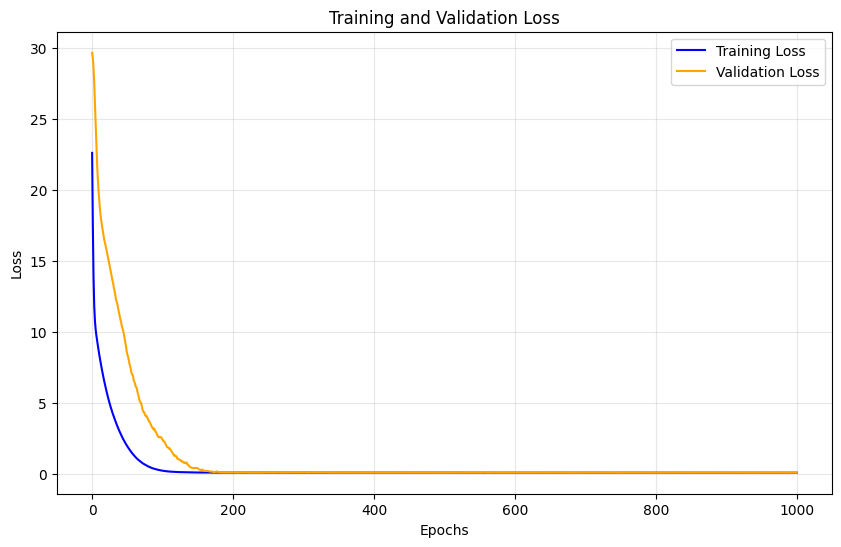

In [4]:
plot_loss(history)

In [3]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

# Prediction & Performance

In [4]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/scaled_o3/input5/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019_4input_scaled_o3.csv')
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :17*5], ctrl_data[:, 17*5]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2025-02-05 09:35:05.636231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1023 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-02-05 09:35:05.637798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22078 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-02-05 09:35:05.639276: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22078 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-02-05 09:35:05.640731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21675 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090,

2/2 [==============================] - 2s 298ms/step


In [15]:
X_emis_test[18]

array([0.81538172, 1.11554962, 1.09052798, 0.95886025, 0.57191188,
       1.21518621, 1.17809668, 1.19762422, 1.10234056, 1.28606321,
       1.11080942, 1.3128983 , 1.16020392, 1.19391959, 1.0188775 ,
       1.03938011, 1.18747818, 1.04983655, 0.97262597, 0.99741723,
       0.79533562, 0.90015688, 0.82735444, 0.89800689, 1.18278677,
       1.18172214, 1.1902329 , 1.28350387, 0.98254825, 0.96507681,
       0.88991129, 0.90506988, 0.77388705, 1.03215871, 1.30477265,
       1.20661095, 1.16056896, 0.69183552, 1.20525367, 1.12659386,
       0.69273192, 0.97098308, 1.09488342, 0.64935481, 1.22104902,
       1.34472755, 1.13329151, 1.1963949 , 1.25394576, 1.22712673,
       0.91624166, 1.02513585, 1.2369763 , 0.86074779, 1.25937038,
       1.24046512, 0.72014232, 1.42036846, 1.04307555, 1.31060005,
       0.69171331, 0.71990495, 0.91142314, 0.69095794, 1.40073342,
       0.69038503, 0.68636916, 0.64088837, 0.8070049 , 1.49660479,
       1.14956261, 0.85470968, 1.13691181, 1.05873891, 1.03603

In [5]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [6]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

In [7]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [30]:
# print((y_test[17].reshape(82,67)))
# print(y_pred[17])
print(get_score((y_test[17].reshape(82,67)), y_pred[17]))

(array([0.02004244, 0.04460206, 0.05322598, 0.04083723, 0.01785975,
       0.02402655, 0.0266858 , 0.03213301, 0.03340508, 0.03150035,
       0.03292344, 0.02900843, 0.03059761, 0.02857636, 0.05249526,
       0.08373202, 0.07013818, 0.05390485, 0.03380768, 0.06210774,
       0.06688094, 0.06777962, 0.04572073, 0.05270768, 0.0516286 ,
       0.05580463, 0.04832396, 0.0445742 , 0.049099  , 0.05203513,
       0.04405315, 0.03719985, 0.03619384, 0.04088435, 0.04397282,
       0.03922211, 0.03950531, 0.03616558, 0.03894318, 0.03593205,
       0.0373782 , 0.03720567, 0.0368671 , 0.03625288, 0.03615331,
       0.03393241, 0.0328015 , 0.03362514, 0.03034236, 0.03150634,
       0.02877039, 0.02738736, 0.02816709, 0.02460887, 0.02377834,
       0.02181935, 0.02149564, 0.02184006, 0.02112243, 0.02423245,
       0.02861171, 0.02767367, 0.02950602, 0.02412501, 0.03860966,
       0.069266  , 0.06855142, 0.04601555, 0.02343119, 0.0407516 ,
       0.05103402, 0.04143882, 0.01959374, 0.03328214, 0.0599

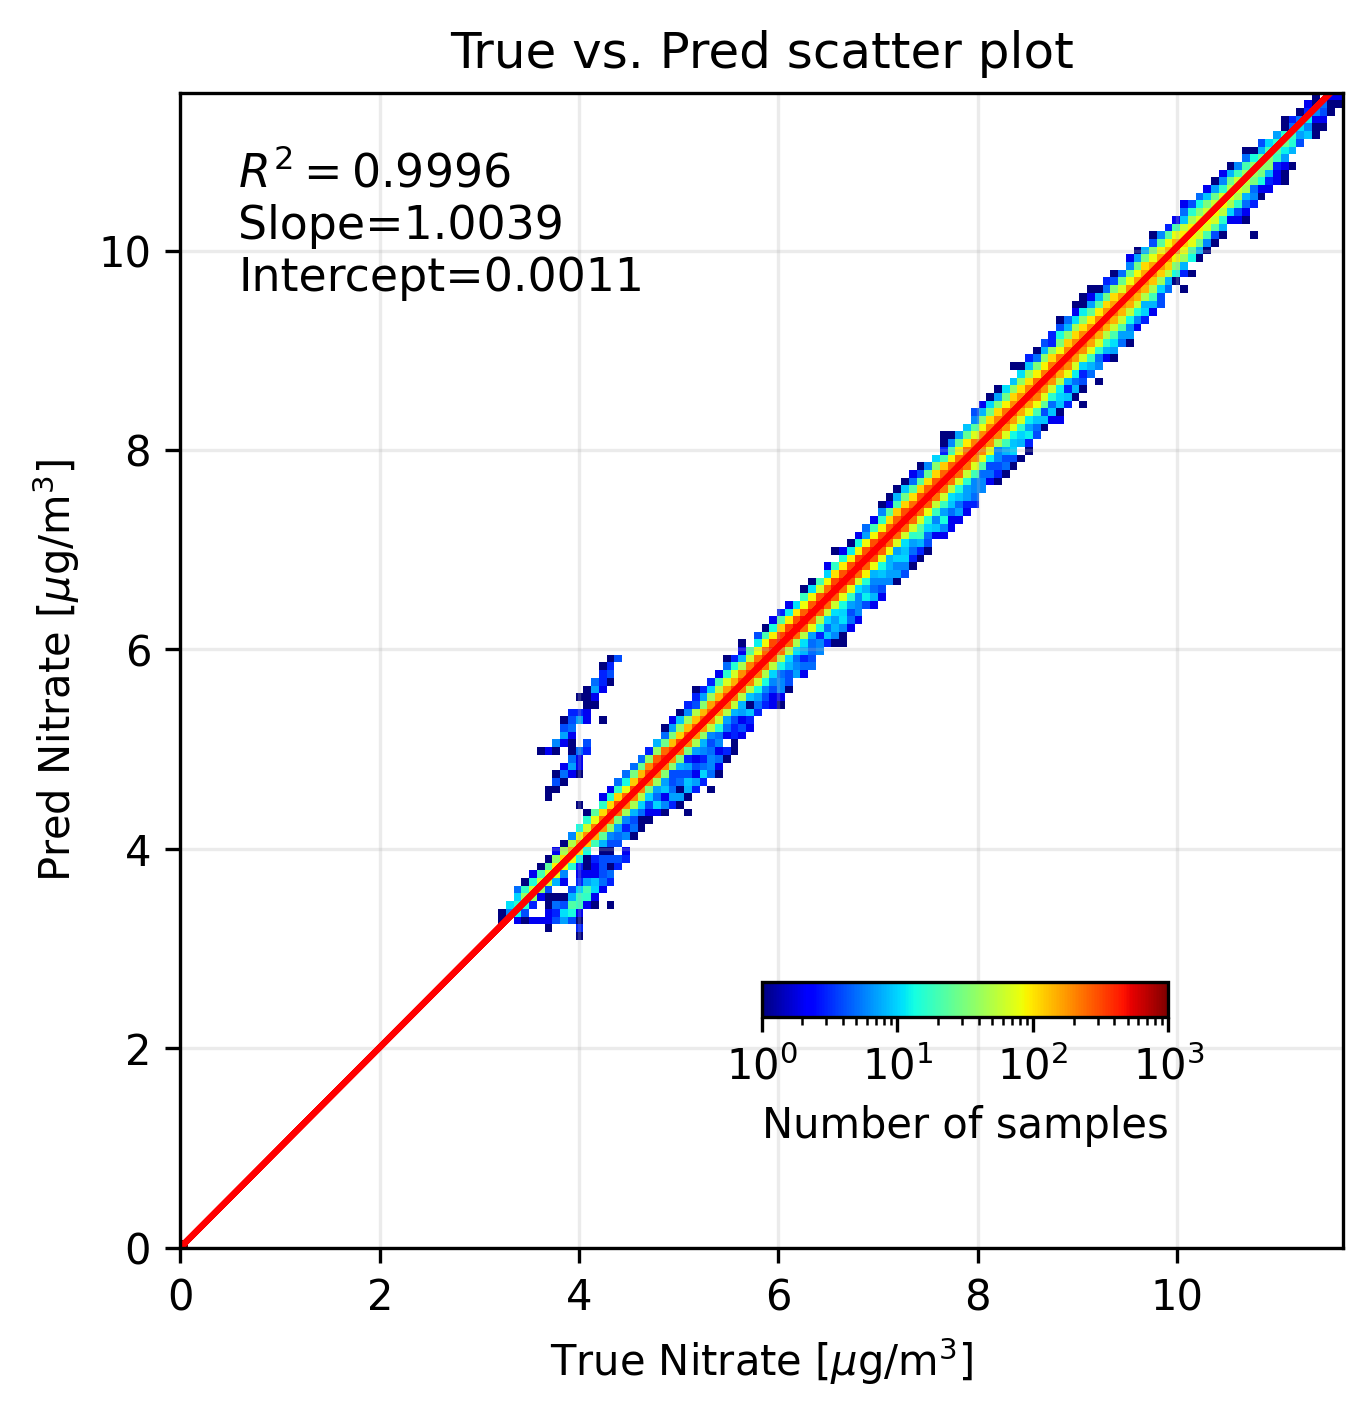

In [8]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
axes = plot_scatter(axes, y_true_modi, y_pred_modi)
axes.grid(alpha=0.25)
axes.set_title("True vs. Pred scatter plot")
axes.set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes.set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes.inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

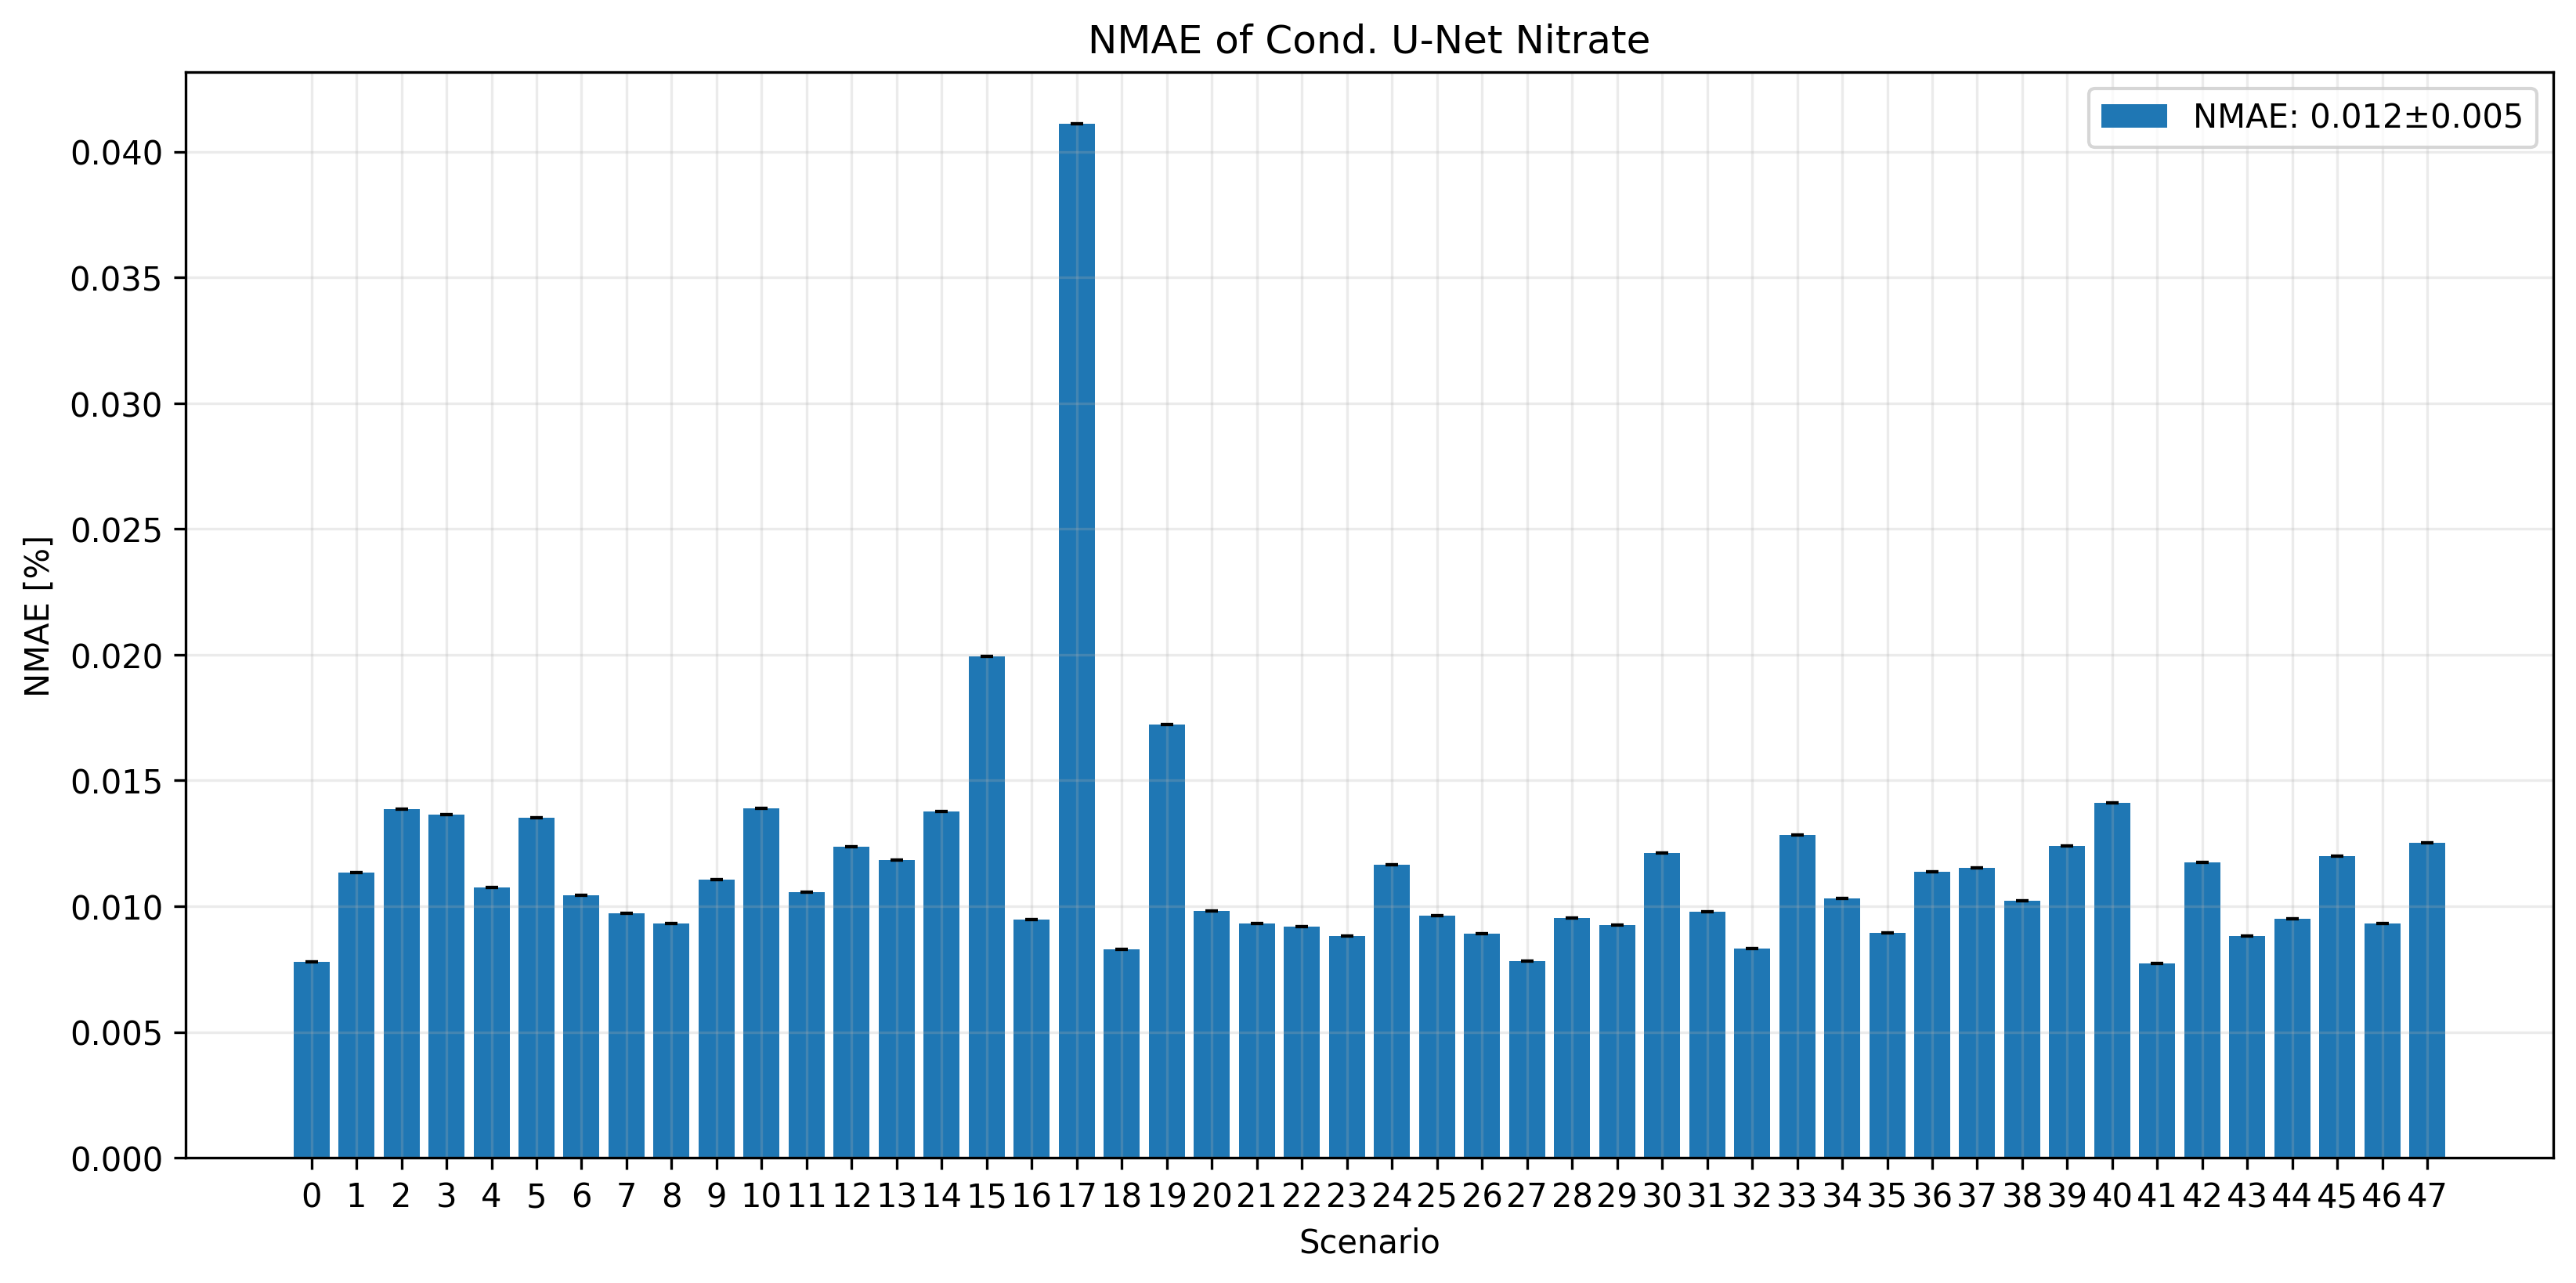

In [9]:
fig, axes = plt.subplots(1, 1, figsize=(13, 6), dpi=300)
score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes.bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes.set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes.grid(alpha=0.25)
axes.legend()
axes.set_title("NMAE of Cond. U-Net Nitrate")
axes.set_xlabel('Scenario')
axes.set_ylabel('NMAE [%]')
plt.show()

[0]


/tmp/ipykernel_1462021/815748241.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462021/815748241.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462021/815748241.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462021/815748241.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462021/815748241.py:67: UserWarning: set_ticklab

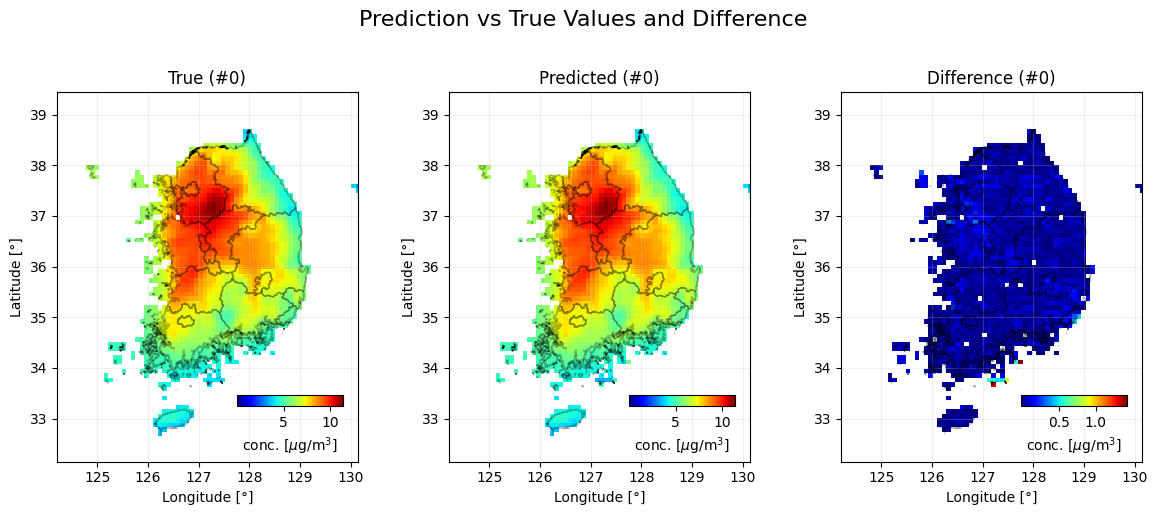

In [12]:
def plot_prediction_loss(y_true, y_pred, num_samples=1, indices=-1):
    if indices == -1 or indices < 0:
        indices = np.random.choice(len(y_true), num_samples, replace=False)
    else:
        index = indices
        indices = []
        indices.append(index) 
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines, indices=0)